In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

import pandas as pd
import numpy as np
import scipy 
import torch
import matplotlib.pyplot as plt

import ripley



In [3]:

#define genes,molecules:
sample_number = "219KS"
coi = ["neoplastic","connective","lymphoid","smooth muscle","non-neoplastic"]   #cell types of interest
goi = []   #genes of interest


#study parameter settings:
microscopy_resolution = 0.1625
ssam_um_p_px = 2.5

# sonar parameters:
max_radius=250

cell_color_file = sample_number+"_custom_colour_celltypes.csv"
coordinate_file = sample_number+"_Decoded_LowThreshold.csv"
cell_map_file = "celltypefile.npy"
data_path = os.path.join("..","..","data",sample_number,)

colors = pd.read_csv(os.path.join(data_path,cell_color_file),header=None)
colors.columns=['celltype','colors']
coordinates = pd.read_csv(os.path.join(data_path,coordinate_file))
celltype_map = np.load(os.path.join(data_path,cell_map_file)).squeeze()

colors["cluster_index"]=colors.celltype.map(lambda x: int(x.split('_')[-1][7:])).values

plotting_colors=[colors[colors.celltype.str.startswith(ct)].iloc[-1,1] for ct in coi]



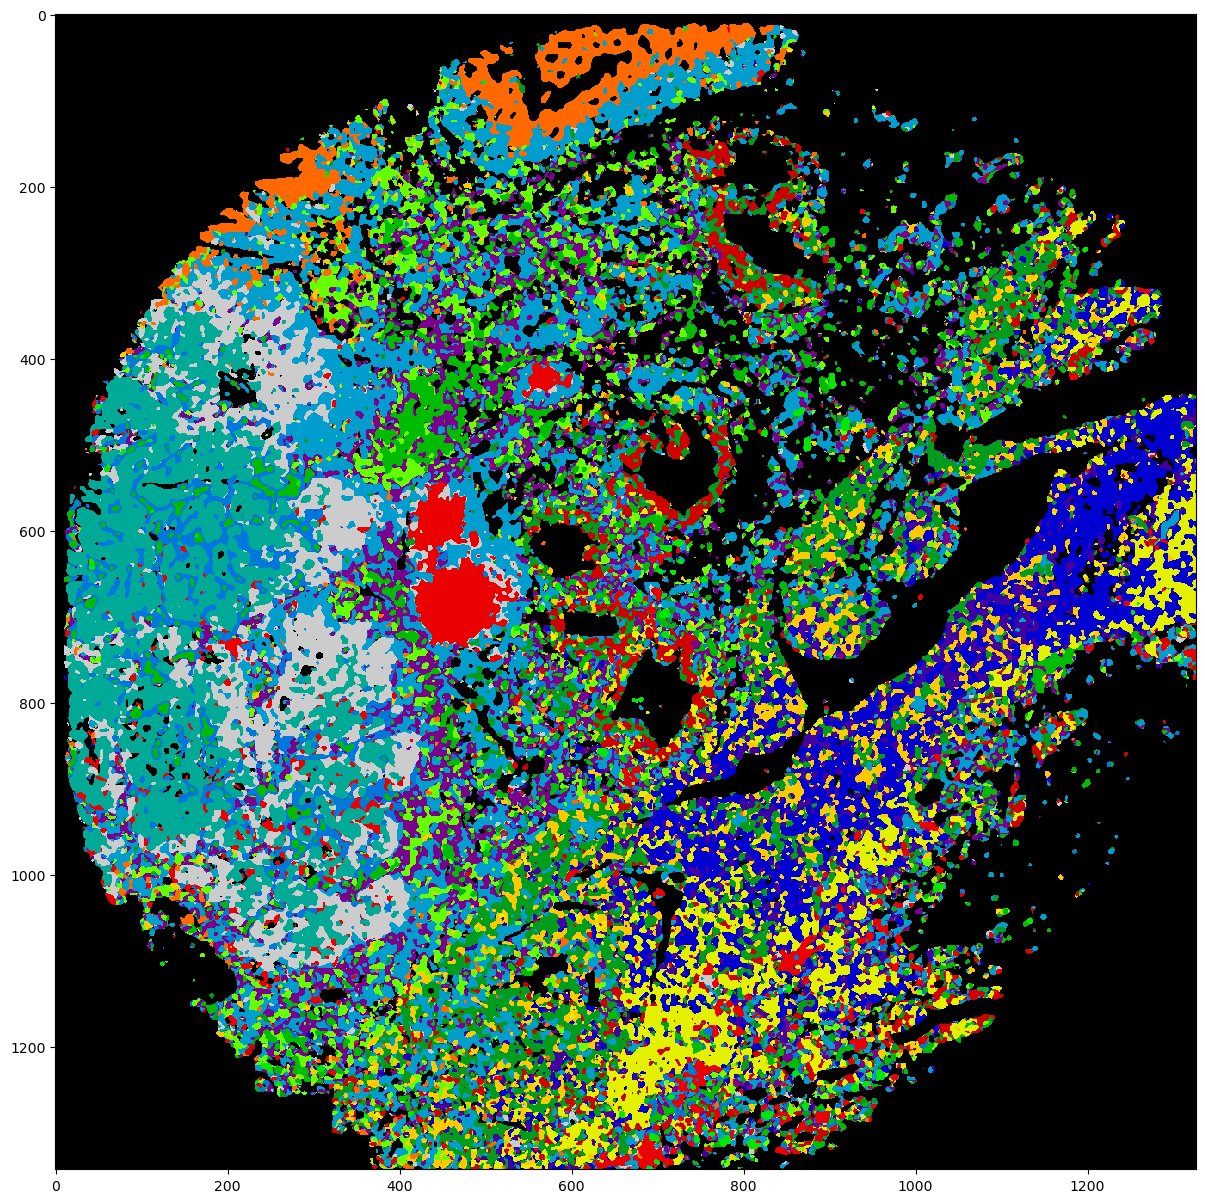

In [4]:
plt.figure(figsize=(15,15))

plt.imshow(celltype_map,cmap='nipy_spectral',interpolation='none')

In [5]:

#rescale coordinates
coordinates['X']*=microscopy_resolution/ssam_um_p_px
coordinates['Y']*=microscopy_resolution/ssam_um_p_px

celltype_matrix = np.zeros((len(goi)+len(coi),)+celltype_map.shape)


In [6]:

i=0
for ct in coi:
    tissue_idcs = np.array(colors[colors.celltype.str.startswith(ct)].cluster_index)
    for idx in tissue_idcs:
        celltype_matrix[i,:,:]+=celltype_map==idx
    i+=1



In [7]:
for g in goi:
    gene_idcs = coordinates.gene
    coordinate_subset = coordinates[coordinates.gene==g]
    kde = np.histogram2d(coordinate_subset.X,coordinate_subset.Y,
                         bins=[np.arange(s+1) for s in celltype_map.shape])
    celltype_matrix[i,:,:] = kde[0]
    i+=1
#     break

In [ ]:
rip = ripley.Ripley(um_per_px=1)
coocs=rip.compute_coocurrences(cell_matrix=celltype_matrix,
                               max_radius=max_radius,linear_steps=max_radius)
dm = rip.radial_integration()

/home/sebastian/src/ISS/scripts/sonar/ripley.py:192: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_sample[:img_shape[0],:img_shape[1]] = torch.tensor(tissue_mask, dtype=torch.float, device=device)


In [ ]:
# rip.run_pipeline(cell_matrix=celltype_matrix,
#                                max_radius=max_radius,linear_steps=max_radius)

In [ ]:
reference = 2
scaling_factor = rip.kernel_areas

for i in range(dm.shape[0]):
    if i<len(plotting_colors):
        plt.plot(dm[reference,i]/scaling_factor/dm[reference,reference,0],color=plotting_colors[i])
    else:
        plt.plot(dm[reference,i]/scaling_factor/dm[reference,reference,0])

plt.legend(coi+goi)

plt.title('Co-occurrence with '+(coi+goi)[reference])
plt.yscale('log')

In [ ]:
plt.imshow(celltype_matrix[0])